In [261]:
from gurobipy import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

# Visualizations and Analysis

def textSummary():
    for i in range(number_of_people):
        idx = 7*i
        num_tests = 0
        days_avail = 0
        for j in range(7):
            num_tests += x0[idx].x
            days_avail += Aeq[i][idx]
            idx += 1
        if (days_avail < num_tests):
            print("!!! Person %02d: available days = %d --> %d tests !!!" % (i, days_avail, num_tests))
        else:
            print("Person %02d: available days = %d --> %d tests" % (i, days_avail, num_tests))

    print()
    for i in range(7):
        tests = 0
        for j in range(i, 7*number_of_people, 7):
            tests += x0[j].x
        print("On day %d, %d tests" % (i, tests))

def displayAeq():
    fig, ax = plt.subplots(figsize=(16,6))
    cmap = colors.ListedColormap(['gray', 'yellow'])

    ax.imshow(Aeq, cmap=cmap, aspect='auto', extent=[0, 7*number_of_people, number_of_people, 0])
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1.2)

    ax.set_xticks(np.arange(0, 7*number_of_people, 7))
    ax.set_yticks(np.arange(0, number_of_people, 2))
    ax.set_ylabel("Person", fontsize=16)
    ax.set_xlabel("Person-Days [yellow=available]", fontsize=16)
    ax.set_title("Aeq (Availability Matrix)", fontsize=20)

    plt.savefig("Aeq.png")
    plt.show()
    plt.close()
    
def displayA():
    fig, ax = plt.subplots(figsize=(16,6))
    cmap = colors.ListedColormap(['gray', 'yellow'])

    ax.imshow(A, cmap=cmap, aspect='auto', extent=[0, 7*number_of_people, 7, 0])
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1.2)

    ax.set_xticks(np.arange(0, 7*number_of_people, 7))
    ax.set_yticks(np.arange(0, 7, 1))
    ax.set_ylabel("Y Axis", fontsize=16)
    ax.set_xlabel("X Axis", fontsize=16)
    ax.set_title("A ", fontsize=20)

    plt.savefig("A.png")
    plt.show()
    plt.close()

def displaybeq():
    fig, ax = plt.subplots(figsize=(16,6))
    cmap = colors.ListedColormap(['gray', 'yellow'])

    # Turn beq numpy array to a flat list of beq values
    beq_list = [item for sublist in beq.tolist() for item in sublist]

    ax.bar(range(number_of_people), height=beq_list)
    ax.set_yticks(range(0, int(max(beq_list)) + 1, 1))
    ax.set_xticks(range(number_of_people))

    ax.set_ylabel("Number of required tests", fontsize=16)
    ax.set_xlabel("Person", fontsize=16)
    ax.set_title("beq (Testing requirement)", fontsize=20)

    plt.savefig("beq.png")
    plt.show()
    plt.close()
    
def makeCalendars(sol):
    avail = np.zeros((1,7))
    for i in range(number_of_people):
        avail = np.append(avail, [Aeq[i][7*i:7*(i+1)]], axis=0)
    avail = np.delete(avail, obj=0, axis=0)

    sched_list = [sol[i].x for i in range(7*number_of_people)]
    for i in range(len(sched_list)):
        if sched_list[i] == 1:
            sched_list[i] = .5
    sched_list = np.asarray(sched_list)
    sched_list = sched_list.reshape(number_of_people,7)
    overlay = np.add(sched_list, avail)
    return avail, sched_list, overlay

def displayAvail(data):
    fig, ax = plt.subplots(figsize=(8,data.shape[0]/5))
    cmap = colors.ListedColormap(['gray', 'yellow'])

    ax.imshow(data, cmap=cmap, aspect='auto', extent=[0, 7, number_of_people, 0])
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1.2)

    # ax.set_xticks(np.arange(0, 7, 7))
    ax.set_yticks(np.arange(0, number_of_people, 1))
    ax.set_ylabel("Person", fontsize=16)
    ax.set_xlabel("Day [yellow=available]", fontsize=16)
    ax.set_title("Availability Matrix", fontsize=20)

    plt.savefig("avail.png")
    plt.show()
    plt.close()
    
def displaySched(data):
    fig, ax = plt.subplots(figsize=(8,data.shape[0]/5))
    cmap = colors.ListedColormap(['gray', 'green'])

    ax.imshow(data, cmap=cmap, aspect='auto', extent=[0, 7, number_of_people, 0])
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1.2)

    # ax.set_xticks(np.arange(0, 7, 7))
    ax.set_yticks(np.arange(0, number_of_people, 1))
    ax.set_ylabel("Person", fontsize=16)
    ax.set_xlabel("Day [green=scheduled]", fontsize=16)
    ax.set_title("Scheduled Matrix", fontsize=20)

    plt.savefig("sched.png")
    plt.show()
    plt.close()
    
def displayOverlay(data):
    fig, ax = plt.subplots(figsize=(8,data.shape[0]/5))
    cmap = colors.ListedColormap(['gray', 'red', 'yellow', 'green'])

    ax.imshow(data, cmap=cmap, aspect='auto', extent=[0, 7, number_of_people, 0])
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1.2)

    # ax.set_xticks(np.arange(0, 7, 7))
    ax.set_yticks(np.arange(0, number_of_people, 1))
    ax.set_ylabel("Person", fontsize=16)
    ax.set_xlabel("Day [yellow=available, green=scheduled, red if overscheduled]", fontsize=12)
    ax.set_title("Calendar", fontsize=20)

    plt.savefig("overlay.png")
    plt.show()
    plt.close()
    
# Create "spread" metric
def spreadCost(x0):
    spread = []
    intervals = []
    
    sched_list = [x0[i].x for i in range(len(x0))]
    sched_list = np.asarray(sched_list)
    sched_list = sched_list.reshape(number_of_people,7)
    
    for week in sched_list:
        scheduled_days = np.where(week!=0)
        if len(scheduled_days[0]) == 2:
            intervals.append(scheduled_days[0][1] - scheduled_days[0][0])
    for interval in intervals:
        spread.append((interval - 3.5) ** 2)
    return sum(spread) / number_of_people

In [262]:
def schedule(number_of_people, tests_per_week):
    
    tests_per_week = 2
    number_of_people = 1000
    buffer = 0.1

    availability_matrix = np.random.randint(0,2, size=(number_of_people, 7*number_of_people)) # random availabilities
    # availability_matrix = np.ones((number_of_people, 7*number_of_people)) # pretend everyone is available, always

    # Zero out irrelevant parts of the matrix
    for i in range(len(availability_matrix)):
        if i > 0:
            for j in range(i*7):
                availability_matrix[i][j] = 0
        if i < len(availability_matrix):
            for j in range((i+1)*7, 7*number_of_people):
                availability_matrix[i][j] = 0

    # Dealing with infeasibles...
    people_total_availability = np.sum(availability_matrix, 1)
    infeasible_people = np.where(people_total_availability < tests_per_week)

    # Enforce that everyone gets two tests a week
    Aeq = availability_matrix
    beq = np.multiply(tests_per_week, np.ones((number_of_people,1)))

    # Loosen beq in the case where people aren't available enough
    for i in range(len(infeasible_people[0])):
        beq[infeasible_people[0][i]][0] = people_total_availability[infeasible_people[0][i]]

    # This picks up the number of total tests (per?) person each day of the week
    testing_capacity_matrix = np.zeros((7, 7*number_of_people))
    for i in range(len(testing_capacity_matrix)):
        for j in range(i, 7*number_of_people, 7):
            testing_capacity_matrix[i][j] = 1

    A = testing_capacity_matrix
    b_value = np.ceil((number_of_people*tests_per_week/7) * (1 + buffer))
    b = np.multiply(b_value, np.ones((7,1))) 
    
    m = Model()

    # Define our scheduling vector as a variable
    x0 = m.addVars(7*number_of_people, name='x0', vtype=GRB.BINARY) # x \in [0,1]

    m.setObjective(x0.sum(), GRB.MAXIMIZE) # maximize # of tests. perhaps not necessary?
    # m.setObjective(spreadCost(x0), GRB.MINIMIZE) # aim to get tests close to Q3.5, not working!

    # Ax <= b -- load balancing
    for i in range(7):
        m.addConstr(sum(x0[j]*A[i][j] for j in range(7*number_of_people)) <= b[i][0])


    # Aeq x = beq -- enforce test-taking
    for i in range(number_of_people):
        m.addConstr(sum((x0[j])*Aeq[i][j] for j in range(7*i, 7*(i+1))) == beq[i][0])
        m.addConstr(sum((x0[j]) for j in range(7*i, 7*(i+1))) == np.floor(beq[i][0]))

    m.optimize()

    avail, sched, overlay = makeCalendars(x0)

    intervals = []
    for week in sched:
        scheduled_days = np.where(week==0.5)
        if len(scheduled_days[0]) == 2:
            intervals.append(scheduled_days[0][1] - scheduled_days[0][0])


    daily_demands = np.multiply(sched.sum(axis=0), 2)
    exp_supply_per_day = number_of_people * tests_per_week / 7
    max_deviation = max(daily_demands.max() - exp_supply_per_day,
                        exp_supply_per_day - daily_demands.max()) / exp_supply_per_day

    return spreadCost(x0), max_deviation

In [263]:
%%time

spreadCosts = []
max_deviations = []
for _ in range(100):
    c, d = schedule(2, 1000)
    print(c, d)
    spreadCosts.append(c)
    max_deviations.append(d)

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 2007 rows, 7000 columns and 17524 nonzeros
Model fingerprint: 0x2fde5133
Variable types: 0 continuous, 7000 integer (7000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 1934.0000000
Presolve removed 1225 rows and 3860 columns
Presolve time: 0.02s
Presolved: 782 rows, 3140 columns, 6280 nonzeros
Variable types: 0 continuous, 3140 integer (3140 binary)

Explored 0 nodes (0 simplex iterations) in 0.05 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 1934 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.934000000000e+03, best bound 1.934000000000e+03, gap 0.0000%
2.862 0.04299999999999997
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 2007 rows, 7000 columns and 17498 nonzeros
Model fingerpri

Presolve removed 1219 rows and 3872 columns
Presolve time: 0.02s
Presolved: 788 rows, 3128 columns, 6256 nonzeros
Variable types: 0 continuous, 3128 integer (3128 binary)

Explored 0 nodes (0 simplex iterations) in 0.03 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 1944 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.944000000000e+03, best bound 1.944000000000e+03, gap 0.0000%
2.84825 0.04299999999999997
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 2007 rows, 7000 columns and 17479 nonzeros
Model fingerprint: 0x6bd46889
Variable types: 0 continuous, 7000 integer (7000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 1929.0000000
Presolve removed 1226 rows and 3902 columns
Presolve time: 0.02s
Presolved: 781 rows, 3098 columns, 6196 nonzeros
Variable types: 0 c

2.77625 0.10249999999999997
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 2007 rows, 7000 columns and 17513 nonzeros
Model fingerprint: 0x4913795f
Variable types: 0 continuous, 7000 integer (7000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 1945.0000000
Presolve removed 1215 rows and 3862 columns
Presolve time: 0.02s
Presolved: 792 rows, 3138 columns, 6276 nonzeros
Variable types: 0 continuous, 3138 integer (3138 binary)

Explored 0 nodes (0 simplex iterations) in 0.04 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 1945 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.945000000000e+03, best bound 1.945000000000e+03, gap 0.0000%
2.8785 0.05699999999999997
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 2007 rows, 7000 columns and 1

Found heuristic solution: objective 1939.0000000
Presolve removed 1201 rows and 3809 columns
Presolve time: 0.03s
Presolved: 806 rows, 3191 columns, 6382 nonzeros
Variable types: 0 continuous, 3191 integer (3191 binary)

Explored 0 nodes (0 simplex iterations) in 0.06 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 1939 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.939000000000e+03, best bound 1.939000000000e+03, gap 0.0000%
2.754 0.04999999999999997
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 2007 rows, 7000 columns and 17478 nonzeros
Model fingerprint: 0x76daa01d
Variable types: 0 continuous, 7000 integer (7000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 1936.0000000
Presolve removed 1215 rows and 3888 columns
Presolve time: 0.02s
Presolved: 792 rows, 

2.69375 0.07799999999999997
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 2007 rows, 7000 columns and 17446 nonzeros
Model fingerprint: 0x8393500f
Variable types: 0 continuous, 7000 integer (7000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 1923.0000000
Presolve removed 1229 rows and 3935 columns
Presolve time: 0.03s
Presolved: 778 rows, 3065 columns, 6130 nonzeros
Variable types: 0 continuous, 3065 integer (3065 binary)

Explored 0 nodes (0 simplex iterations) in 0.05 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 1923 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.923000000000e+03, best bound 1.923000000000e+03, gap 0.0000%
2.8055 0.02549999999999997
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 2007 rows, 7000 columns and 1

Found heuristic solution: objective 1918.0000000
Presolve removed 1238 rows and 3982 columns
Presolve time: 0.02s
Presolved: 769 rows, 3018 columns, 6036 nonzeros
Variable types: 0 continuous, 3018 integer (3018 binary)

Explored 0 nodes (0 simplex iterations) in 0.04 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 1918 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.918000000000e+03, best bound 1.918000000000e+03, gap 0.0000%
2.69375 0.004499999999999971
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 2007 rows, 7000 columns and 17547 nonzeros
Model fingerprint: 0x255c5753
Variable types: 0 continuous, 7000 integer (7000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 1931.0000000
Presolve removed 1202 rows and 3788 columns
Presolve time: 0.03s
Presolved: 805 row

2.8085 0.009500000000000028
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 2007 rows, 7000 columns and 17511 nonzeros
Model fingerprint: 0xf433e3eb
Variable types: 0 continuous, 7000 integer (7000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 1930.0000000
Presolve removed 1243 rows and 3905 columns
Presolve time: 0.03s
Presolved: 764 rows, 3095 columns, 6190 nonzeros
Variable types: 0 continuous, 3095 integer (3095 binary)

Explored 0 nodes (0 simplex iterations) in 0.04 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 1930 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.930000000000e+03, best bound 1.930000000000e+03, gap 0.0000%
2.82225 0.06749999999999996
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 2007 rows, 7000 columns and 

Presolve removed 1217 rows and 3873 columns
Presolve time: 0.02s
Presolved: 790 rows, 3127 columns, 6254 nonzeros
Variable types: 0 continuous, 3127 integer (3127 binary)

Explored 0 nodes (0 simplex iterations) in 0.04 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 1939 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.939000000000e+03, best bound 1.939000000000e+03, gap 0.0000%
2.60175 0.01849999999999997
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 2007 rows, 7000 columns and 17495 nonzeros
Model fingerprint: 0x94963e7c
Variable types: 0 continuous, 7000 integer (7000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 1930.0000000
Presolve removed 1232 rows and 3899 columns
Presolve time: 0.02s
Presolved: 775 rows, 3101 columns, 6202 nonzeros
Variable types: 0 c

2.877 0.0025000000000000282
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 2007 rows, 7000 columns and 17509 nonzeros
Model fingerprint: 0x5889ed56
Variable types: 0 continuous, 7000 integer (7000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 1934.0000000
Presolve removed 1219 rows and 3863 columns
Presolve time: 0.02s
Presolved: 788 rows, 3137 columns, 6274 nonzeros
Variable types: 0 continuous, 3137 integer (3137 binary)

Explored 0 nodes (0 simplex iterations) in 0.04 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 1934 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.934000000000e+03, best bound 1.934000000000e+03, gap 0.0000%
2.83725 0.04649999999999997
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 2007 rows, 7000 columns and 

Found heuristic solution: objective 1942.0000000
Presolve removed 1213 rows and 3825 columns
Presolve time: 0.02s
Presolved: 794 rows, 3175 columns, 6350 nonzeros
Variable types: 0 continuous, 3175 integer (3175 binary)

Explored 0 nodes (0 simplex iterations) in 0.03 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 1942 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.942000000000e+03, best bound 1.942000000000e+03, gap 0.0000%
2.7875 0.04299999999999997
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 2007 rows, 7000 columns and 17493 nonzeros
Model fingerprint: 0x1c213b70
Variable types: 0 continuous, 7000 integer (7000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 1922.0000000
Presolve removed 1230 rows and 3889 columns
Presolve time: 0.02s
Presolved: 777 rows,

2.7825 0.00799999999999997
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 2007 rows, 7000 columns and 17503 nonzeros
Model fingerprint: 0x15d6b478
Variable types: 0 continuous, 7000 integer (7000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 1918.0000000
Presolve removed 1213 rows and 3841 columns
Presolve time: 0.02s
Presolved: 794 rows, 3159 columns, 6318 nonzeros
Variable types: 0 continuous, 3159 integer (3159 binary)

Explored 0 nodes (0 simplex iterations) in 0.03 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 1918 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.918000000000e+03, best bound 1.918000000000e+03, gap 0.0000%
2.675 0.01849999999999997
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 2007 rows, 7000 columns and 175

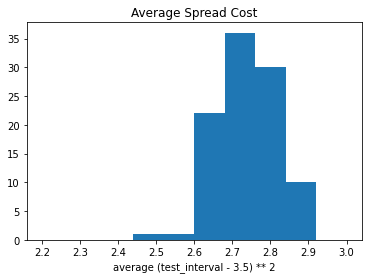

In [265]:
plt.title("Average Spread Cost")
plt.hist(spreadCosts, range=(2.4,3.0), bins=10)
plt.xlabel("average (test_interval - 3.5) ** 2")
plt.show()

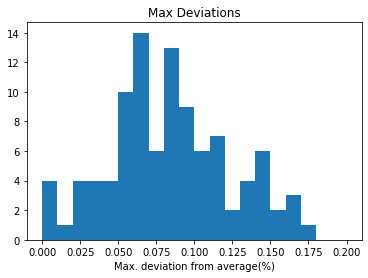

In [260]:
plt.title("Max Deviations")
plt.hist(max_deviations, range=(0,0.2), bins=20)
plt.xlabel("Max. deviation from average(%)")
plt.show()

# Detailed stats for latest run

In [106]:
print('Daily demand (min):', daily_demands.min())
print('Daily demand (max):', daily_demands.max())
print('All daily demands:', daily_demands)
exp_supply_per_day = number_of_people * tests_per_week / 7
print(exp_supply_per_day)
max_deviation = max(daily_demands.max() - exp_supply_per_day,
                    exp_supply_per_day - daily_demands.max()) / exp_supply_per_day
print("Max Deviation:", 100 * max_deviation)

Daily demand (min): 243.0
Daily demand (max): 298.0
All daily demands: [278. 298. 280. 276. 268. 277. 243.]
285.7142857142857
Max Deviation: 4.299999999999997


In [ ]:
print("--- Tests by Spacing ---")
for i in range(1,7):
    print('{:d} days: {:d}'.format(i, intervals.count(i)))

# Visualizing the schedule

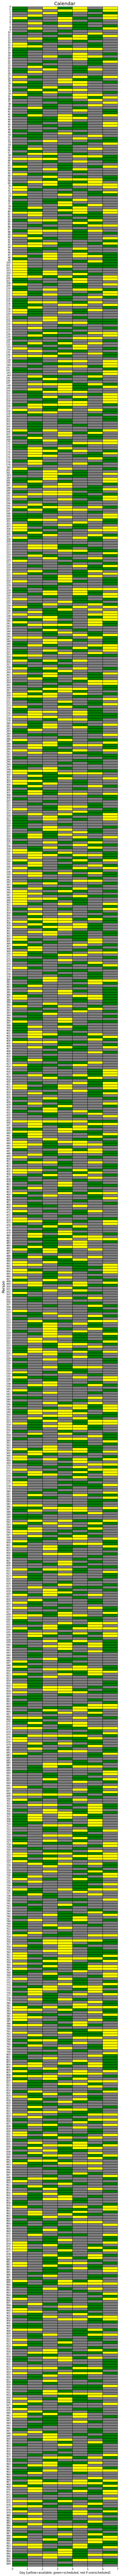

In [30]:
displayOverlay(overlay)